<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sergsb/IUPAC2Struct.git

fatal: destination path 'IUPAC2Struct' already exists and is not an empty directory.


In [ ]:
import sys
import torch
sys.path.append("/content/IUPAC2Struct")
M = torch.load("/content/IUPAC2Struct/models/iupac2smiles_model.pt")

In [3]:
M.predict_single

<bound method Model.predict_single of <model.Model object at 0x7a1825833550>>

In [4]:
M.T.encoder

Encoder(
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (WQ): Linear(in_features=512, out_features=512, bias=True)
        (WK): Linear(in_features=512, out_features=512, bias=True)
        (WV): Linear(in_features=512, out_features=512, bias=True)
        (WO): Linear(in_features=512, out_features=512, bias=True)
      )
      (resnorm1): ResidualNorm(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): MLP(
        (w1): Linear(in_features=512, out_features=2048, bias=True)
        (w2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (resnorm2): ResidualNorm(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (lnorm): LayerNorm()
)

In [6]:
M.device = torch.device('cuda:0')

In [7]:
import numpy as np
import pylab

src = torch.tensor(np.random.randint(0,15, size=(512)), device=(M.device))
M.T.src_embedder(src).shape

torch.Size([1, 512, 512])

In [89]:
def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch

pad_pack([
    [1,2,3],
    [1,2,3,4,5,6]
])

tensor([[1, 2, 3, 0, 0, 0],
        [1, 2, 3, 4, 5, 6]])

In [7]:
#what? I can run the next block now and just now it says size error?

<ipython-input-93-1cba059c6ccd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(pad_pack([inp]), device=(M.device))


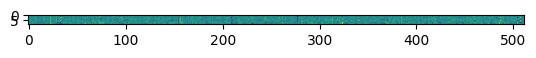

In [93]:
inp = M.src_model.encode("N-(4-hydroxyphenyl)acetamide")
src = torch.tensor(pad_pack([inp]), device=(M.device))
src_mask = (src != 0).unsqueeze(-2).to(M.device)#.shape
latent = M.T.encoder(M.T.src_embedder(src), (src != 0).unsqueeze(-2).to(M.device))
l = latent.to(torch.device("cpu"))
pylab.imshow(l.detach().numpy()[0])

(array([  1.,  16.,  36.,  58., 106.,  62., 114.,  58.,  41.,  20.]),
 array([-0.17491306, -0.14353961, -0.11216614, -0.08079269, -0.04941923,
        -0.01804577,  0.01332769,  0.04470115,  0.07607461,  0.10744807,
         0.13882153]),
 <BarContainer object of 10 artists>)

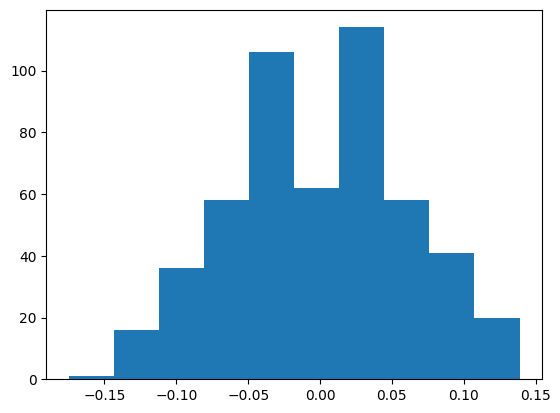

In [94]:
def subsequent_mask(tgt_mask):
    size = tgt_mask.size(-1)
    return tgt_mask.to(torch.uint8) & torch.tril(torch.ones(1,size,size, dtype=torch.uint8)).to(tgt_mask.device)

tgt = torch.tensor(np.array([2]*512), device=M.device)
out = M.T.decoder(M.T.tgt_embedder(tgt), latent, src_mask, subsequent_mask((tgt != 0).unsqueeze(-2)))
out = out[:,-1].view(1, 1, out.shape[-1]).mean(dim=1)
pylab.hist(torch.sort(out, dim=1, descending=True)[0].cpu().detach().numpy()[0])

In [109]:
tgt = [[2]]

def find_first_working(x):
  for i in x:
    if i<=71:
      return i

for i in range(300):
  padded_tgt = pad_pack(tgt).to(M.device)
  out = M.T.decoder(M.T.tgt_embedder(padded_tgt), latent, src_mask, subsequent_mask((padded_tgt != 0).unsqueeze(-2)))
  out = M.T.generator(out) # I was reading the code and found that I forgot this
  out = out[:,-1].view(1, 1, out.shape[-1]).mean(dim=1)
  tgt[0].append(find_first_working(torch.sort(out, dim=1, descending=True)[1].cpu().detach().numpy()[0]))
print(M.tgt_model.decode(tgt[0])) #WHAT? Run again and worked? oh i ran that first!

CC(=O)Nc1ccc(O)cc1Cccc1C(C(O)C(C(C)c1c(C(C)cccc1)C(C(O)C(C(C)=C(C(C)c1ccc1)C(C(C(C)=O)c1cccccc(O)cc(C(O)C(C(C)C(C(C)c1ccc(O)CC(=O)C(C(O)C(C(C(C)C(C(C)C(C(=O)C(CC(C)C(C(C(C)c1ccccc1)CC(CC(C(C)=Occccc1)cc(O)C(C(C)C)CC(O)C(C(C)cccC(O)C(C(=O)C(C(C)c1ccccccccccccccccC(CCCCCC(C)C(C(=OCCCC(C)C(C(C)c1cCC(


CC(=O)Nc1ccc(O)cc1Cccc1C(C(O)C(C(C)c1c(C(C)cccc1)C(C(O)C(C(C)=C(C(C)c1ccc1)C(C(C(C)=O)c1cccccc(O)cc(C(O)C(C(C)C(C(C)c1ccc(O)CC(=O)C(C(O)C(C(C(C)C(C(C)C(C(=O)C(CC(C)C(C(C(C)c1ccccc1)CC(CC(C(C)=Occccc1)cc(O)C(C(C)C)CC(O)C(C(C)cccC(O)C(C(=O)C(C(C)c1ccccccccccccccccC(CCCCCC(C)C(C(=OCCCC(C)C(C(C)c1cCC(


In [74]:
M.predict_single("N-(4-hydroxyphenyl)acetamide")

(['CC(=O)Nc1ccc(O)cc1'], [0.9955432111912935])